In [1]:
import sys

!{sys.executable} -m pip install matplotlib kagglehub opencv-python 
import os
import sys
import shutil  
import kagglehub
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Asus\Desktop\DLMI\Brain_Tumor_Segmentation_\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not os.path.exists("blood_cell_images"):
    path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")
    shutil.copytree(path, "retinal_images", dirs_exist_ok=True)
    print("Dataset downloaded.")
else:
    print("Dataset already exists.")

Dataset downloaded.


In [3]:
BASE_DIR = os.getcwd()

TRAIN_DIR = os.path.join(BASE_DIR, "retinal_images", "DRIVE", "training")

IMAGE_DIR = os.path.join(TRAIN_DIR, "images")
GT_DIR = os.path.join(TRAIN_DIR, "1st_manual")
MASK_DIR = os.path.join(TRAIN_DIR, "mask")

image_files = sorted(os.listdir(IMAGE_DIR))

print("Total training images:", len(image_files))


Total training images: 20


In [4]:
def load_data(image_name):

    img_path = os.path.join(IMAGE_DIR, image_name)

    
    img_number = image_name.split("_")[0]

    gt_name = f"{img_number}_manual1.gif"
    gt_path = os.path.join(GT_DIR, gt_name)

    mask_name = f"{img_number}_training_mask.gif"
    mask_path = os.path.join(MASK_DIR, mask_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt_path, 0)
    gt = (gt > 0).astype(np.uint8)
    
    mask = cv2.imread(mask_path, 0)
    mask = (mask > 0).astype(np.uint8)

    if gt is None:
        print("GT not found:", gt_path)

    if mask is None:
        print("Mask not found:", mask_path)



    return img, gt, mask


In [5]:
def segment_vessels(img, method="niblack",
                    window_size=25,
                    k=0.2,
                    debug=False):

    green = img[:, :, 1]

   
    # CLAHE (increase contrast)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    green = clahe.apply(green)

    if method == "niblack":
        thresh = threshold_niblack(green,
                                   window_size=window_size,
                                   k=k)
    else:
        thresh = threshold_sauvola(green,
                                   window_size=window_size,
                                   k=k)

    binary = (green < thresh).astype(np.uint8)

    return binary

In [6]:
def compute_metrics(pred, gt, mask):

    pred = pred[mask == 1]
    gt = gt[mask == 1]

    tp = np.sum((pred == 1) & (gt == 1))
   
    fn = np.sum((pred == 0) & (gt == 1))

    sensitivity = tp / (tp + fn + 1e-8)
    

    return sensitivity

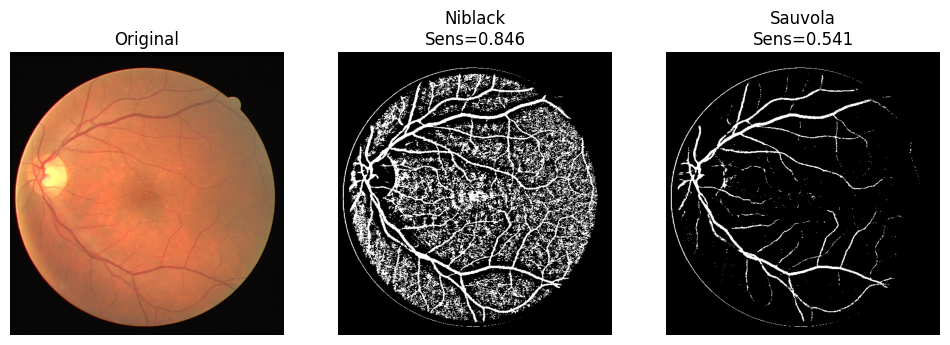

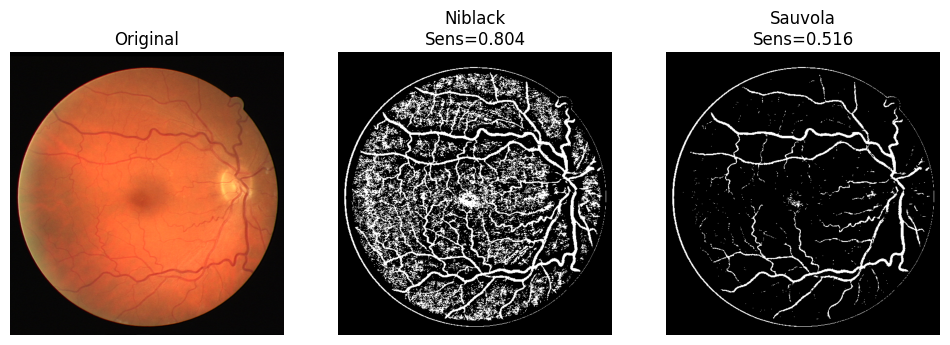

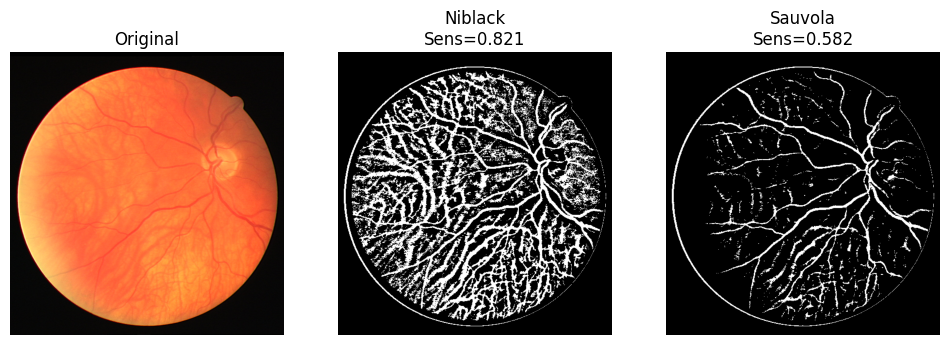

Average Sensitivity : 
Niblack: 0.8172922348269918
Sauvola: 0.539585272285455


In [7]:
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

niblack_sens = []
sauvola_sens = []

show_count = 3

for idx, image_name in enumerate(image_files):

    img, gt, mask = load_data(image_name)
    
    pred_niblack = segment_vessels(img, method="niblack")
    pred_sauvola = segment_vessels(img, method="sauvola")

    # Apply mask
    pred_niblack = pred_niblack * mask
    pred_sauvola = pred_sauvola * mask

    
    sens_n = compute_metrics(pred_niblack, gt, mask)
    sens_s = compute_metrics(pred_sauvola, gt, mask)

    niblack_sens.append(sens_n)
    sauvola_sens.append(sens_s)

    
    if idx < show_count:

        plt.figure(figsize=(12,5))

        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(pred_niblack, cmap="gray")
        plt.title(f"Niblack\nSens={sens_n:.3f}")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_sauvola, cmap="gray")
        plt.title(f"Sauvola\nSens={sens_s:.3f}")
        plt.axis("off")

        plt.show()

   
    cv2.imwrite(os.path.join(results_dir, f"niblack_{image_name}"),
                pred_niblack * 255)

    cv2.imwrite(os.path.join(results_dir, f"sauvola_{image_name}"),
                pred_sauvola * 255)


print("Average Sensitivity : ")
print("Niblack:", np.mean(niblack_sens))
print("Sauvola:", np.mean(sauvola_sens))

# Analysis:

Niblack has overall higher sensitivity than Sauvola

### For Niblack:
As we increase K, Sensitivity decreases 

at K=-0.1,  avg sensitivity is 0.88

at K=0.1,  avg sensitivity is 0.84

at K=0.2,  avg sensitivity is 0.81

at k= 0.7, avg sensitivity is 0.66

at k=1,    avg sensitivity is 0.56  



### For Sauvola:


at K=-0.1,  avg sensitivity is 0.93

at K=0.1,  avg sensitivity is 0.74

at K=0.2,  avg sensitivity is 0.53

at k= 0.7, avg sensitivity is 0.044

at k=1,    avg sensitivity is 0.0064  


